In [70]:
#Inital imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
from lifetimes.plotting import plot_period_transactions, plot_calibration_purchases_vs_holdout_purchases
from lifetimes import BetaGeoFitter
from datetime import timedelta
from datetime import datetime
from dateutil import parser

In [20]:
#Load in our pre-prepared dataframe
lifetimes_object_df = pd.read_csv("data/lifetimes_object_df.csv")
lifetimes_object_df.head(5)

,order_id,customer_unique_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value
0,00e7ee1b050b8499577073aeb2a297a1,861eff4711a542e4b93843c6dd7febb0,delivered,2017-05-16,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,146.87
1,29150127e6685892b6eab3eec79f59c7,290c77bc529b7ac935b93aa66c333dc3,delivered,2018-01-12,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,335.48
2,b2059ed67ce144a36e2aa97d2c9e9ad2,060e732b5b29e8181a18229c7b0b2b5e,delivered,2018-05-19,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,157.73
3,951670f92359f4fe4a63112aa7306eba,259dac757896d24d7702b9acbbff3f3c,delivered,2018-03-13,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,173.30
4,6b7d50bd145f6fc7f33cebabd7e49d0f,345ecd01c38d18a9036ed96c73b8d066,delivered,2018-07-29,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,252.25


In [22]:
#It seems we only have 3,345 repeat buyers, this could be a major issue.
len(list(lifetimes_object_df.customer_unique_id)) - len(set(list(lifetimes_object_df.customer_unique_id)))

3345

### Data wrangling into lifetimes object

In [23]:
#Load in our data wrangler
from lifetimes.utils import summary_data_from_transaction_data

In [25]:
summary = summary_data_from_transaction_data(transactions=lifetimes_object_df,customer_id_col='customer_unique_id',
                                             datetime_col='order_purchase_timestamp',monetary_value_col='payment_value',observation_period_end='2018-10-17')
summary

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,160.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,163.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,586.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,370.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,337.0,0.0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,496.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,311.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,617.0,0.0


In [68]:
#We have less than 3% of customers who are repeat purchasers
summary.frequency.value_counts(normalize=True)

0.0     0.977637
1.0     0.020636
2.0     0.001384
3.0     0.000198
5.0     0.000062
4.0     0.000052
6.0     0.000021
16.0    0.000010
Name: frequency, dtype: float64

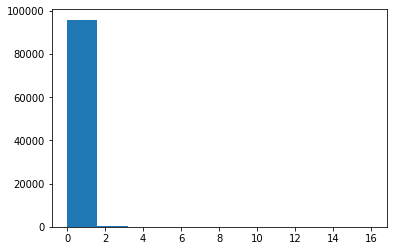

In [66]:
plt.hist(summary.frequency);

### Split of Training and Test Dataset

In [31]:
#Import holdout 
from lifetimes.utils import calibration_and_holdout_data

In [54]:
# days to preserve for evaluation
t_evaluation = 240                                         

#save the end of our data set observation
max_obs_date = lifetimes_object_df["order_purchase_timestamp"].max()
print("max transaction date observed:", max_obs_date)
#convert to date-time
max_obs_date = parser.parse(max_obs_date)

#save the end of our calibaration observation
max_calib_date = max_obs_date - timedelta(days=t_evaluation)
print("max calibration date observed:", max_calib_date)

df_ch = calibration_and_holdout_data(
        transactions = lifetimes_object_df, 
        customer_id_col='customer_unique_id',
        datetime_col='order_purchase_timestamp',
        monetary_value_col='payment_value',
        calibration_period_end = max_calib_date, 
        observation_period_end = max_obs_date, 
        freq = "D")
df_ch

max transaction date observed: 2018-10-17
max calibration date observed: 2018-02-19 00:00:00


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,0.0,0.0,346.0,0.0,0.0,0.0,240.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,130.0,0.0,0.0,0.0,240.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,97.0,0.0,0.0,0.0,240.0
0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,352.0,0.0,0.0,0.0,240.0
0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.0,216.0,0.0,0.0,0.0,240.0
...,...,...,...,...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,0.0,0.0,54.0,0.0,0.0,0.0,240.0
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,256.0,0.0,0.0,0.0,240.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,71.0,0.0,0.0,0.0,240.0


###  1.0 BG/NBD model
Model features
- Uncleaned data
Model results
- Terrrible
- Our model is way off because we have such an imbalence of customers who never made a repeat purchase.
Next steps
- Drop customers with less than 2 orders

In [56]:
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(
        frequency = df_ch["frequency_cal"], 
        recency = df_ch["recency_cal"], 
        T = df_ch["T_cal"],   
        weights = None,  
        verbose = True,)

Optimization terminated successfully.
         Current function value: 0.069008
         Iterations: 63
         Function evaluations: 64
         Gradient evaluations: 64


<lifetimes.BetaGeoFitter: fitted with 55206 subjects, a: 1.41, alpha: 64.28, b: 0.24, r: 0.02>

In [58]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.016649,0.001412,0.013881,0.019417
alpha,64.279302,9.025972,46.588398,81.970207
a,1.408032,0.508808,0.410768,2.405296
b,0.239673,0.094287,0.054872,0.424475


/Applications/anaconda3/envs/lifetime-env/lib/python3.10/site-packages/lifetimes/generate_data.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)


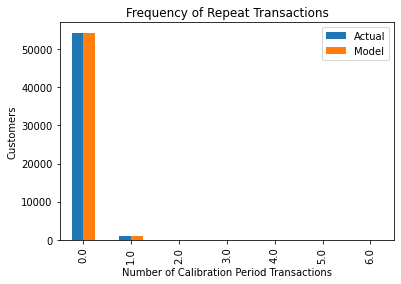

In [61]:
plot_period_transactions(bgf);

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

<Figure size 504x504 with 0 Axes>

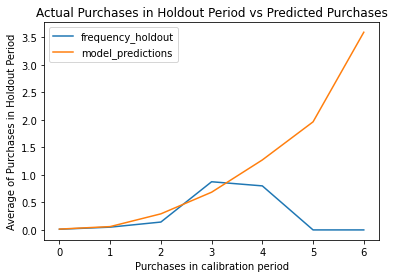

In [64]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch)

In [69]:
#Our model is way off because we have such an imbalence of customers who never made a repeat purchase.